# Week 2 - Function 5 ((21DP, 4D))

# Setup
Let's load all the imports in the top to avoid repeating and simplify the readability of each solution.

In [3]:
import numpy as np

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, ConstantKernel, WhiteKernel
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.stats import norm

from utils.plotting_utils import (
    plot_4D_initial_data,
    plot_output_outliers,
)

# Plan
Recap we have the following data: ((21, 4)) - 21DP & 4D, that can be found `./data/week_2/function_5/`.

0. Setup:
    1. Load the data
    2. Analyse raw data - visualise data and see patterns
    3. Normalise input & output - this will make it easier to work with the data
    4. Analyse normalise data - verify (visually should look the same)
    5. Output outliers
    6. Early results
1. Build probabilistic Model
2. Acquisition Function


# 0.1. Setup > Load the data

In [2]:
X_train_raw = np.load(r"./data/week_2/function_5/inputs.npy")
y_train_raw = np.load(r"./data/week_2/function_5/outputs.npy")

print(f"Shape: X={X_train_raw.shape}, y={y_train_raw.shape}")
print(f"X range: [{X_train_raw.min():.4f}, {X_train_raw.max():.4f}]")
print(f"y range: [{y_train_raw.min():.2e}, {y_train_raw.max():.2e}]")

Shape: X=(21, 4), y=(21,)
X range: [0.0382, 0.9576]
y range: [1.13e-01, 1.09e+03]


# 0.2. Setup > Analyse raw data

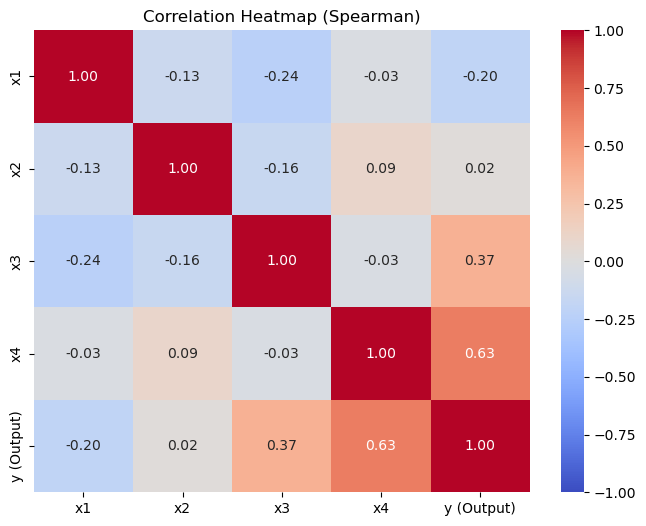

Generating Pairplot...


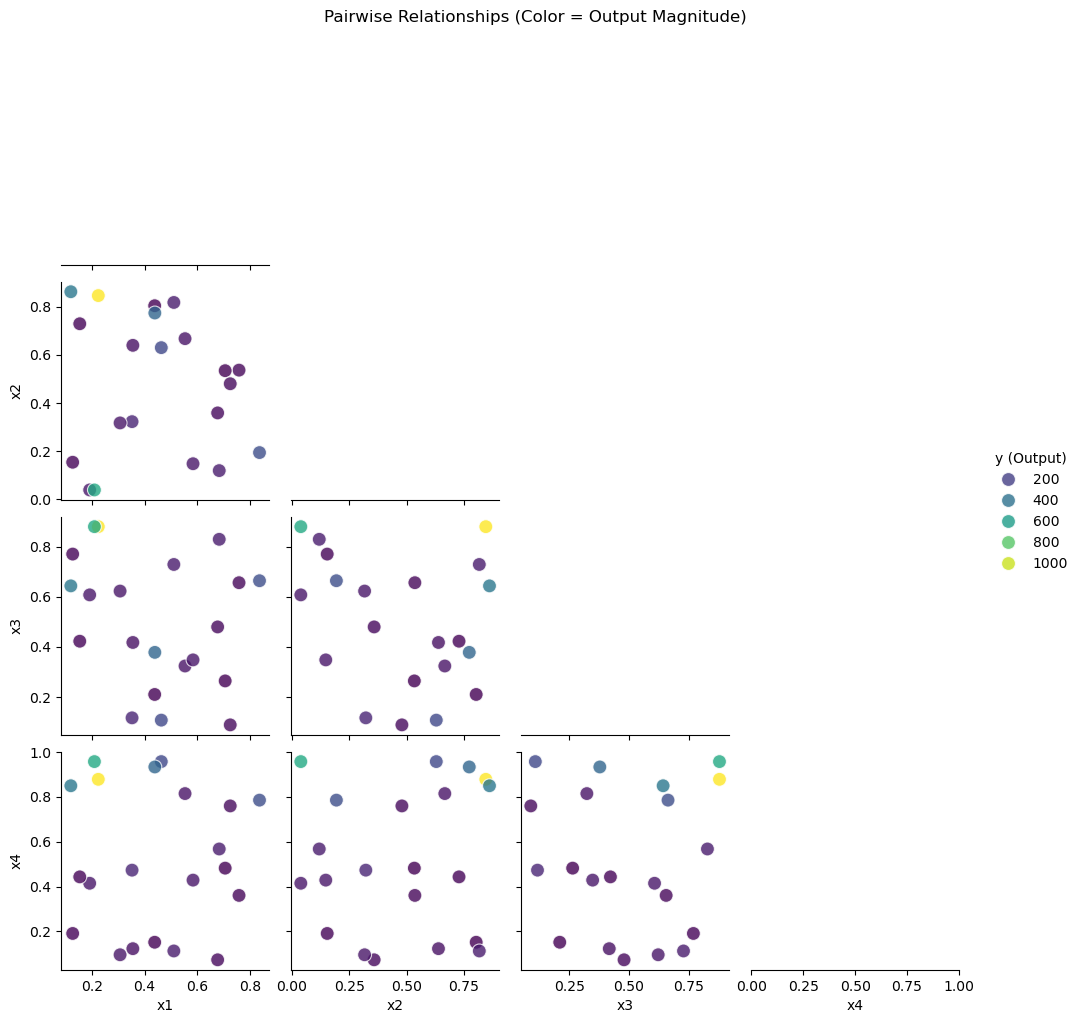

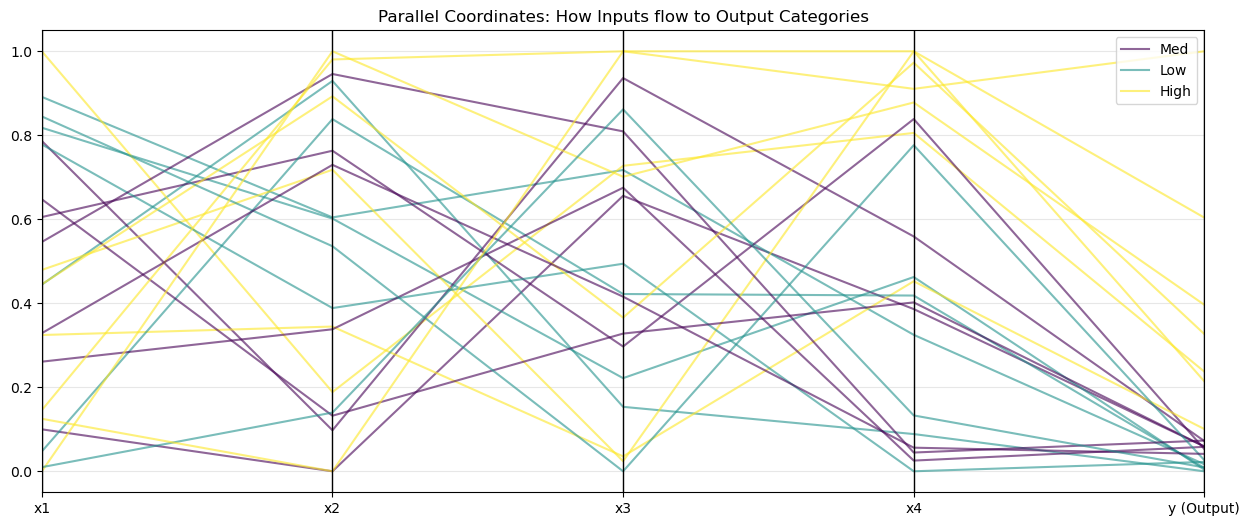

In [3]:
plot_4D_initial_data(X_train_raw, y_train_raw, "Step1: Data points", f"""
DATA SUMMARY
─────────────────────
Points: {len(X_train_raw)}
Input shape: {X_train_raw.shape}
Output shape: {y_train_raw.shape}


CURRENT BEST
─────────────────────
Current best: {np.max(y_train_raw)}
At input: {X_train_raw[np.argmax(y_train_raw)]}
""")

# 0.3. Setup > Normalise the data

In [4]:
# Normalise the data so is easier to visualise + plus needed for BO
# =================================================================
scaler_X = MinMaxScaler()
scaler_y = StandardScaler()

X_train = scaler_X.fit_transform(X_train_raw)
y_train = scaler_y.fit_transform(y_train_raw.reshape(-1, 1)).ravel()

# 0.4. Setup > Analyse normalise data

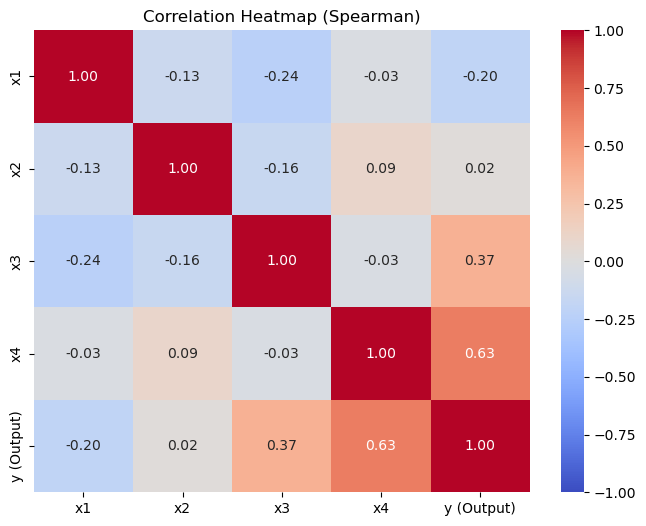

Generating Pairplot...


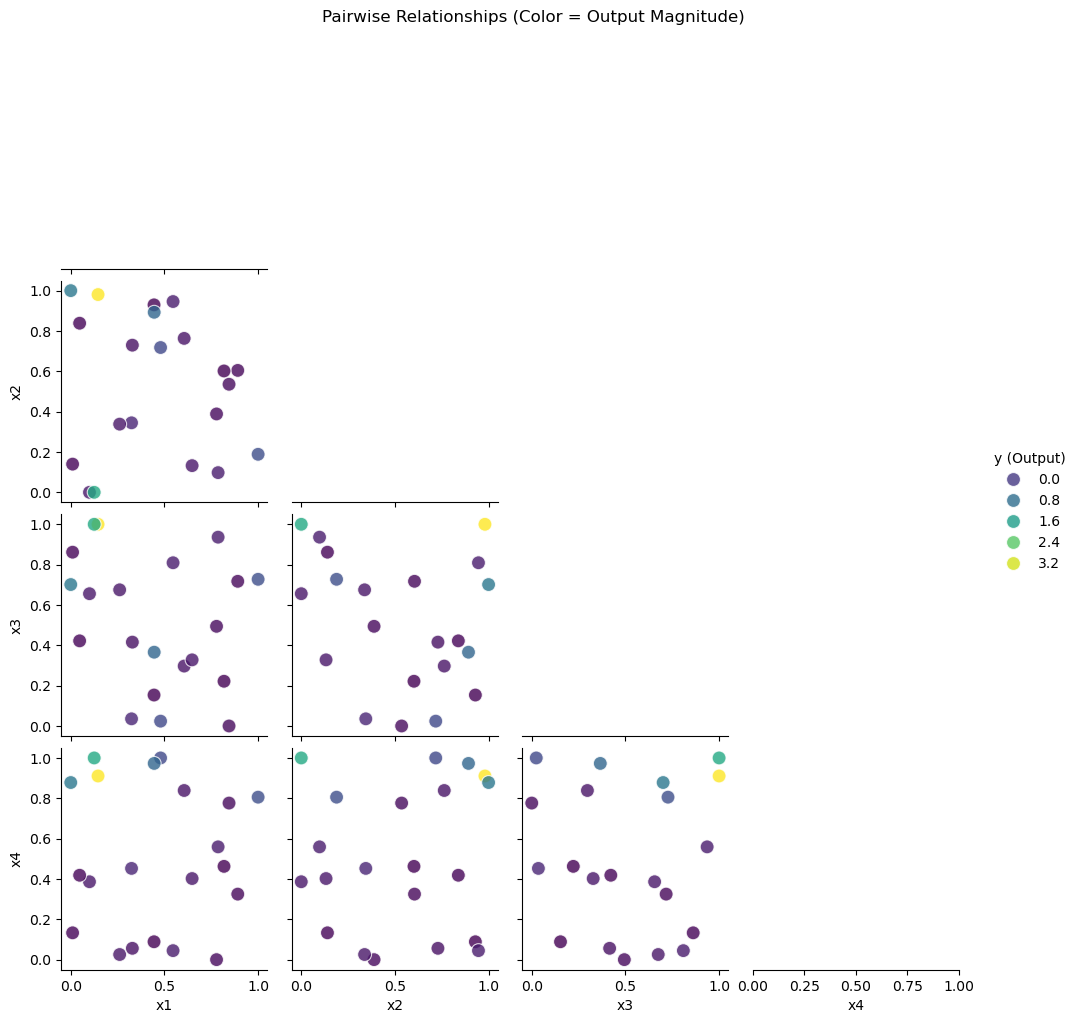

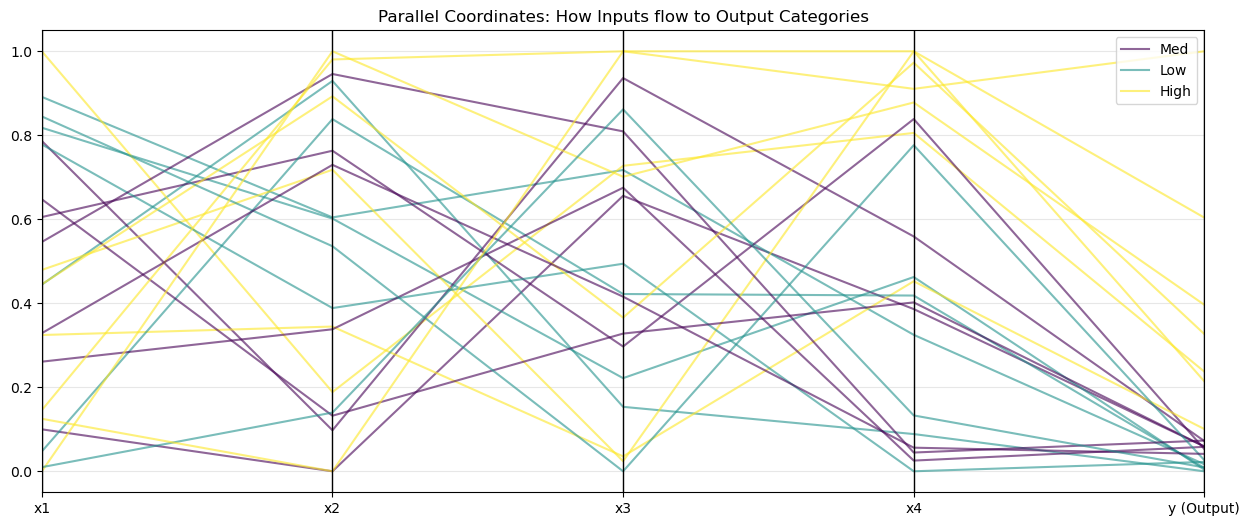

In [5]:
plot_4D_initial_data(X_train, y_train, "Step 4: Normalised", f"""
DATA SUMMARY
─────────────────────
Points: {len(X_train)}
Input shape: {X_train.shape}
Output shape: {y_train.shape}


CURRENT BEST
─────────────────────
Current best: {np.max(y_train)}
At input: {X_train[np.argmax(y_train)]}
""")

# Plan
We now have ((11, 2)) - 10DP & 2D that can be found `./data/week_1/function_2/`.

0. Setup:
    1. Load new data and previous week data
    2. Compare normalise data plot
    3. Early result
1. Build probabilistic Model
2. Acquisition Function


# 0.5. Setup > Output outliers

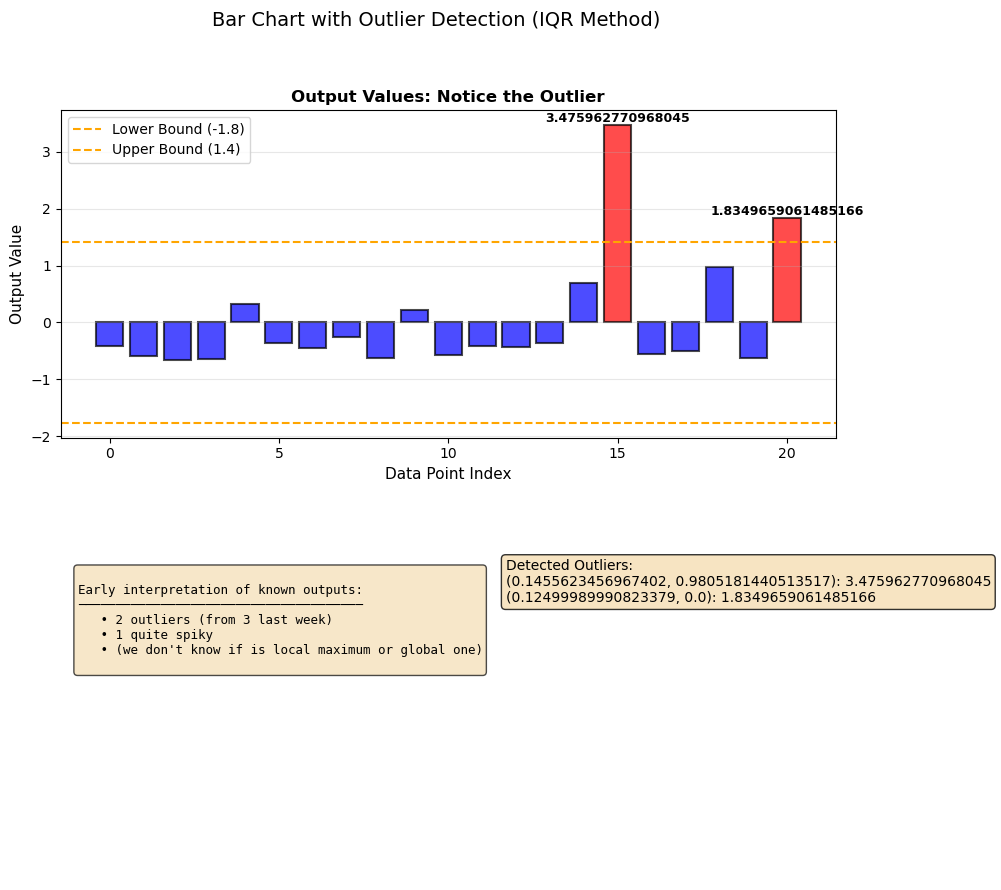

In [6]:
plot_output_outliers(X_train, y_train, "Bar Chart with Outlier Detection (IQR Method)", f"""
Early interpretation of known outputs:
──────────────────────────────────────
   • 2 outliers (from 3 last week)
   • 1 quite spiky
   • (we don't know if is local maximum or global one)
""")

# 0.6. Setup > Early data points & outputs analyze

- $x_4$ has strongest correlation with output:
    - Heatmaps shows that clearly: (0.58).
    - Pairplot shows that where $x_1$ pair is low, it shows the lighter color (higher output).
- $x_2$, $x_3$ low correlation:
    - Heatmaps shows that clearly, $x_2$: (-0.47) & $x_2$: (-0.45)
- $x_1$ low correlation with output


# 1. Build probabilistic Model

From early exploration we know that:
- 3 outliers
- 1 quite spiky
- $x_4$ looks like the highest correlation

## Kernel choice
- Matern 3/2 to allow sharper output peaks

In [7]:
# Step 1: Kernel + Model
# ======================
kernel = (
    ConstantKernel(1.0, (1e-10, 1e3)) * Matern(
        length_scale=[1.0, 1.0, 1.0, 1.0],
        length_scale_bounds=(1e-10, 1e11),
        nu=1.5
    ) + 
    WhiteKernel(noise_level=0.1, noise_level_bounds=(1e-10, 1.0))
)

model = GaussianProcessRegressor(
    kernel=kernel,
    n_restarts_optimizer=10,
    normalize_y=True
)

model.fit(X_train, y_train)
print(f"Optimized Kernel: {model.kernel_}")

# Check what the model learned about x3
learned_scales = model.kernel_.k1.k2.length_scale
print(f"Learned Length Scales: {learned_scales} (learned that in reality 2 is not important)")


#  Create prediction grid
n_grid = 25
x1_range = np.linspace(max(0, X_train[:, 0].min() - 0.5), min(0.999999, X_train[:, 0].max() + 0.5), n_grid)
x2_range = np.linspace(max(0, X_train[:, 1].min() - 0.5), min(0.999999, X_train[:, 1].max() + 0.5), n_grid)
x3_range = np.linspace(max(0, X_train[:, 2].min() - 0.5), min(0.999999, X_train[:, 2].max() + 0.5), n_grid)
x4_range = np.linspace(max(0, X_train[:, 3].min() - 0.5), min(0.999999, X_train[:, 3].max() + 0.5), n_grid)

X1_test, X2_test, X3_test, X4_test = np.meshgrid(x1_range, x2_range, x3_range, x4_range)
X_grid = np.c_[X1_test.ravel(), X2_test.ravel(), X3_test.ravel(), X4_test.ravel()]

# Make predictions
mu, sigma = model.predict(X_grid, return_std=True)


Optimized Kernel: 1.74**2 * Matern(length_scale=[2.39e+10, 2.54, 0.982, 0.642], nu=1.5) + WhiteKernel(noise_level=4.73e-09)
Learned Length Scales: [2.38554243e+10 2.54144567e+00 9.82309013e-01 6.41722903e-01] (learned that in reality 2 is not important)


# 2. Acquisition function

From early exploration we know that:
- $x_4$ is drives most of the grow
- with the current understanding $x_4$, $x_3$, $x_2$ looks when they are the highest, they return the highest output

So I think Expected Improvement (EI), since we can have flexibility for exploration and exploitation.

In [8]:
def expected_improvement(mu, sigma, y_best, xi=0.1):
    """
    Expected Improvement acquisition function

    EI = E[max(f(x) - f(x_best), 0)]
    
    Parameters:
        mu: Mean predictions from GP
        sigma: Standard deviation from GP
        y_best: Current best observed value (in normalized space)
        xi: Exploration parameter (higher = more exploration)
        
    Returns:
        ei: Expected improvement values
    """
    with np.errstate(divide='warn'):
        improvement = mu - y_best - xi
        Z = improvement / sigma
        ei = improvement * norm.cdf(Z) + sigma * norm.pdf(Z)
        ei[sigma == 0.0] = 0.0
    return ei

y_best_norm = np.max(y_train)

xi = 0.1

ei_values = expected_improvement(mu, sigma, y_best_norm, xi=xi)

print(f"\nExpected Improvement (EI):")
print(f"  Min: {ei_values.min():.8f}")
print(f"  Max: {ei_values.max():.8f}")
print(f"  Mean: {ei_values.mean():.8f}")

print("\nSTEP 7: Finding best next point to evaluate...")

best_idx = np.argmax(ei_values)
x_next_norm = X_grid[best_idx]
ei_best = ei_values[best_idx]

# Convert to original space
x_next_orig = scaler_X.inverse_transform([x_next_norm])[0]

print(f"\n{'='*80}")
print(f"RECOMMENDED NEXT POINT")
print(f"{'='*80}")
print(f"\nIn original space:")
print(f"  Input 1: {x_next_orig[0]:.6f}")
print(f"  Input 2: {x_next_orig[1]:.6f}")
print(f"  Input 3: {x_next_orig[2]:.6f}")
print(f"  Input 4: {x_next_orig[3]:.6f}")
print(f"\nIn normalized space:")
print(f"  Input 1: {x_next_norm[0]:.6f}")
print(f"  Input 2: {x_next_norm[1]:.6f}")
print(f"  Input 3: {x_next_norm[2]:.6f}")
print(f"  Input 4: {x_next_norm[3]:.6f}")

# Get prediction at this point
y_pred_next, y_std_next = model.predict([x_next_norm], return_std=True)
y_pred_next_orig = scaler_y.inverse_transform([[y_pred_next[0]]])[0, 0]

print(f"\nPredicted output at this point:")
print(f"  Normalized: {y_pred_next[0]:.6f} ± {y_std_next[0]:.6f}")
print(f"  Original: {y_pred_next_orig:.6f}")
print(f"  95% CI: [{y_pred_next_orig - 1.96*y_std_next[0]:.6f}, {y_pred_next_orig + 1.96*y_std_next[0]:.6f}]")

print(f"\nExpected Improvement at this point: {ei_best:.8f}")


Expected Improvement (EI):
  Min: 0.00000000
  Max: 0.22251371
  Mean: 0.00013013

STEP 7: Finding best next point to evaluate...

RECOMMENDED NEXT POINT

In original space:
  Input 1: 0.119879
  Input 2: 0.862539
  Input 3: 0.879483
  Input 4: 0.957643

In normalized space:
  Input 1: 0.000000
  Input 2: 0.999999
  Input 3: 0.999999
  Input 4: 0.999999

Predicted output at this point:
  Normalized: 3.739825 ± 0.310070
  Original: 1158.202224
  95% CI: [1157.594487, 1158.809961]

Expected Improvement at this point: 0.22251371
